In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
np.random.seed(123)
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Reading and Cleaning the Dataset

In [143]:
# By: Adam Gregg

# Reading the data as a dataframe
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [144]:
# Displaying the basic info of the dataset
df.describe(include = 'all')
df.info()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Hansen, Mr. Henry Damsgaard",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [145]:
# Dropping the columns that don't contribute to survival
# The Cabin attribute may be dropped because it contains too many null values making it incomplete
# The PassengerID and Ticket attributes may be dropped because they are random unique identifiers 
# that have no impact on survival in any way and thus can be ignored. 
# The Name attribute may be dropped because it doesn't neccessarily contribute to survival, however we will analyze this varibale later
df = df.drop(['PassengerId', 'Ticket', 'Cabin'], axis = 1)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


## Dealing With Null Values in the Dataset

In [146]:
# Determining the total amount of null values in each column 
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

Text(0.5,1,'Age Distribution of Passengers on the Titanic')

Text(0.5,0,'Age')

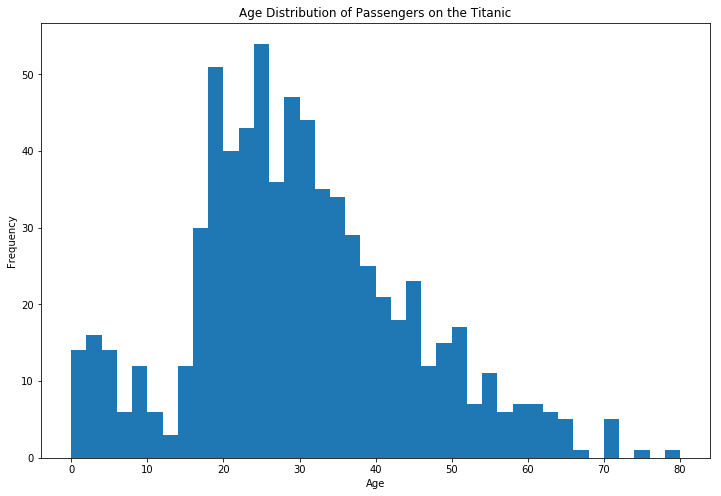

In [147]:
# Let's first take a look at the age distribution in a histogram plot
age_dist_plot = df.Age.plot.hist(bins = range(0,81,2), figsize = [12,8]) 
plt.title('Age Distribution of Passengers on the Titanic')
plt.xlabel('Age')

In [148]:
# Since the Age distribution is approximately normal, this means that about 68% of the data 
# values are within one standard deviation of the mean.
# Thus, in order to fill the missing values for age, I will first produce random integers in the range of 
# (Age mean - Age standard deviation, Age mean + Age standard deviation) for all 177 null values.
# These random ages will then be added to the 'Age' column replacing all the null values
Age_stddev = df.Age.std()
Age_mean = df.Age.mean()
Age_estimate = np.random.randint(Age_mean - Age_stddev, Age_mean + Age_stddev, size = df.Age.isnull().sum())
df.loc[df.Age.isnull(), 'Age'] = Age_estimate

In [149]:
# The other column with null values is the Embarked attribute
# let's first take a closer look at this attribute
df.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [150]:
# Since 'S' is the most common port of embarkation, the missing values will be filled with the mode 'S'
df.Embarked.fillna(df.Embarked.mode()[0], inplace = True)
# Making sure there are no more null values
df.isnull().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

## Who was more likely to Survive? Complete List of all Attributes with Feature Engineering

In order to determine what categories of passengers were most likely to survive the titanic disaster, I will be comparing every attribute in the cleaned dataset to the 'Survived' attribute. I will begin each section by grouping an attribute with 'Survived' and displaying the 'value counts' which show the amount of passengers who survived and who did not. Next, I will create a dataframe which displays the mean as a percentage of the passengers who survived within that particular attribute. The results in each section will then be plotted as bar graphs in order to interpret the data and to compare the different categories. I will also engineer certain attributes in order to give us a clearer and more in-depth understanding of who had a better chance of surviving the titanic.

## Sex vs Survival

To begin our analysis of what categories of passengers were most likely to survive, let's determine the amount of males and females who survived and who did not survive the titanic disaster.

Survived  Sex   
0         male      468
          female     81
1         female    233
          male      109
Name: Sex, dtype: int64

,Survived
Sex,
female,0.742038
male,0.188908


Text(0.5,1,'Rate of Survival: Male vs. Female')

Text(0,0.5,'Survival Rate (%)')

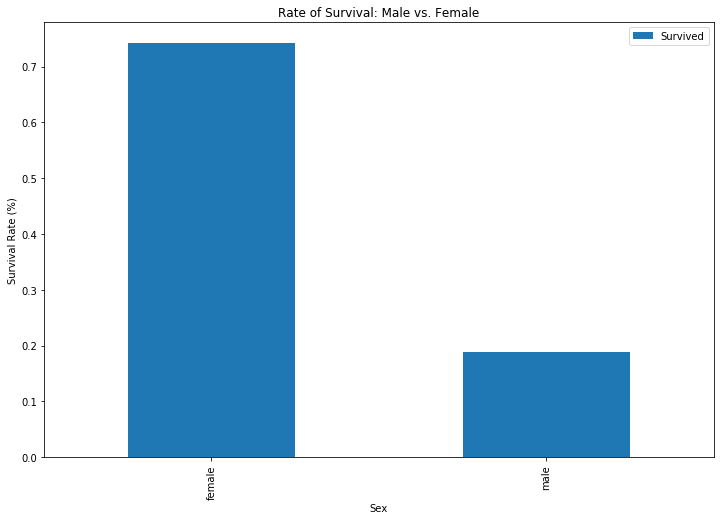

In [151]:
df.groupby('Survived')['Sex'].value_counts()
perc_surv = df[['Survived', 'Sex']].groupby(['Sex']).mean()
perc_surv
ax = perc_surv.plot.bar(figsize = [12,8])
plt.title('Rate of Survival: Male vs. Female')
plt.ylabel('Survival Rate (%)')

Conclusion: Based on the results, 74.2% of the females survived whereas only 18.89% of the males survived the disaster.

## Socio-Economic Status vs Survival

Let's now analyze the Pclass (Socio-Economic Status) of the passengers aboard the titanic to determine which ticket class (Upper, Middle or Lower) had the best chance of survival.

Survived  Pclass
0         3         372
          2          97
          1          80
1         1         136
          3         119
          2          87
Name: Pclass, dtype: int64

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


Text(0.5,1,'Rate of Survival According to Socio-Economic Status')

Text(0,0.5,'Survival Rate (%)')

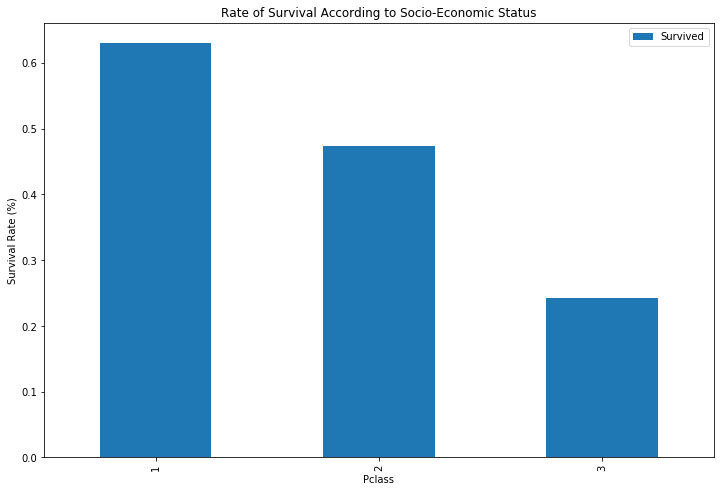

In [152]:
df.groupby('Survived')['Pclass'].value_counts()
perc_surv = df[['Survived', 'Pclass']].groupby(['Pclass']).mean()
perc_surv
ax = perc_surv.plot.bar(figsize = [12,8])
plt.title('Rate of Survival According to Socio-Economic Status')
plt.ylabel('Survival Rate (%)')

Conclusion: The results show that 62.96% of the passengers in the 1st (Upper) class survived whereas only 47.28% and 24.23% of the passengers in the 2nd (Middle) and 3rd (Lower) class respectively survived. 

## Family Size vs Survival

The attributes 'SibSp' (# of siblings/spouses aboard the Titanic) and 'Parch' (# of parents/children aboard the Titanic) will be briefly analyzed to determine the survival rate of different amounts of siblings/spouses and parents/children aboard the Titanic. Next, a new attribute called "Family size" will be engineered which will combine the attributes 'SibSp' and 'Parch' plus one in order to determine the total amount of members in each family. This will enable us to determine which size family had the best chance of survival. Following this, I will then engineer another attribute called "Alone/Not Alone" which will give us further information of the survival rate of passengers who were alone compared to passengers who were not alone (i.e. any family size > 1).

Survived  SibSp
0         0        398
          1         97
          2         15
          4         15
          3         12
          8          7
          5          5
1         0        210
          1        112
          2         13
          3          4
          4          3
Name: SibSp, dtype: int64

,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


Text(0.5,1,'Rate of Survival According to the number of siblings/spouses aboard the Titanic')

Text(0,0.5,'Survival Rate (%)')

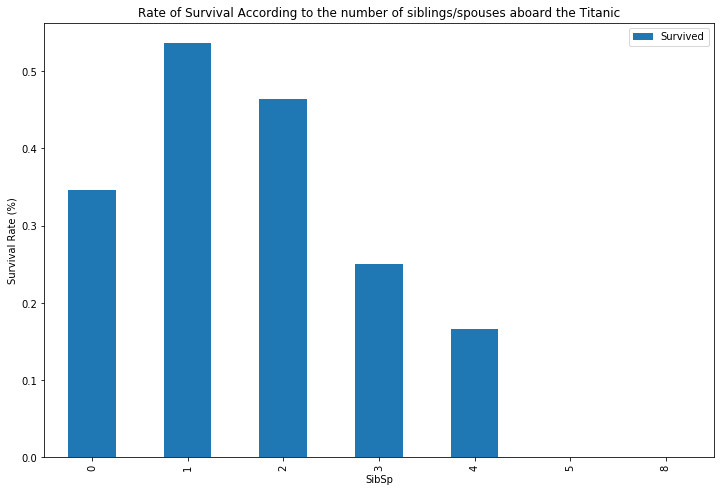

In [153]:
df.groupby('Survived')['SibSp'].value_counts()
perc_surv = df[['Survived', 'SibSp']].groupby(['SibSp']).mean()
perc_surv
ax = perc_surv.plot.bar(figsize = [12,8])
plt.title('Rate of Survival According to the number of siblings/spouses aboard the Titanic')
plt.ylabel('Survival Rate (%)')

Survived  Parch
0         0        445
          1         53
          2         40
          4          4
          5          4
          3          2
          6          1
1         0        233
          1         65
          2         40
          3          3
          5          1
Name: Parch, dtype: int64

,Survived
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


Text(0.5,1,'Rate of Survival According to the number of parents/children aboard the Titanic')

Text(0,0.5,'Survival Rate (%)')

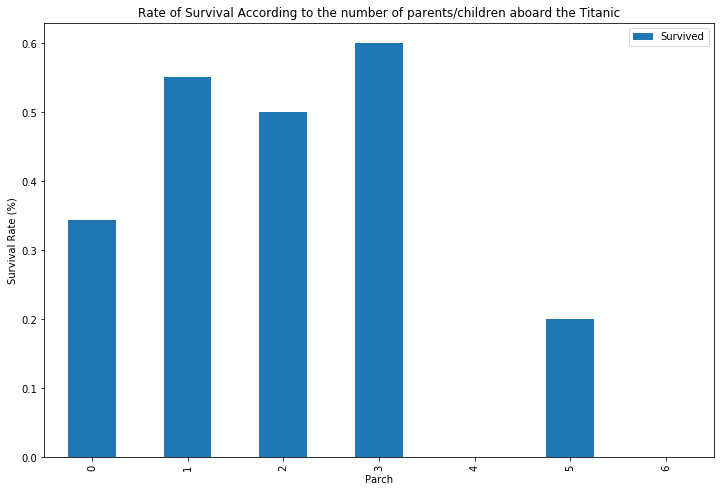

In [154]:
df.groupby('Survived')['Parch'].value_counts()
perc_surv = df[['Survived', 'Parch']].groupby(['Parch']).mean()
perc_surv
ax = perc_surv.plot.bar(figsize = [12,8])
plt.title('Rate of Survival According to the number of parents/children aboard the Titanic')
plt.ylabel('Survival Rate (%)')

In [155]:
# Engineering a new attribute 'Family Size' which will combine SibSp and Parch
df['Family Size'] = df['SibSp'] + df['Parch'] + 1
df.head()
# We can now safely drop the attributes 'SibSp' and 'Parch' from the dataframe
df = df.drop(['SibSp', 'Parch'], axis = 1)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Family Size
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,2
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


,Survived,Pclass,Name,Sex,Age,Fare,Embarked,Family Size
0,0,3,"Braund, Mr. Owen Harris",male,22.0,7.2500,S,2
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,71.2833,C,2
2,1,3,"Heikkinen, Miss. Laina",female,26.0,7.9250,S,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,53.1000,S,2
4,0,3,"Allen, Mr. William Henry",male,35.0,8.0500,S,1


Survived  Family Size
0         1              374
          2               72
          3               43
          6               19
          5               12
          4                8
          7                8
          11               7
          8                6
1         1              163
          2               89
          3               59
          4               21
          7                4
          5                3
          6                3
Name: Family Size, dtype: int64

,Survived
Family Size,
1,0.303538
2,0.552795
3,0.578431
4,0.724138
5,0.200000
6,0.136364
7,0.333333
8,0.000000
11,0.000000


Text(0.5,1,'Rate of survival according to Family size')

Text(0,0.5,'Survival Rate')

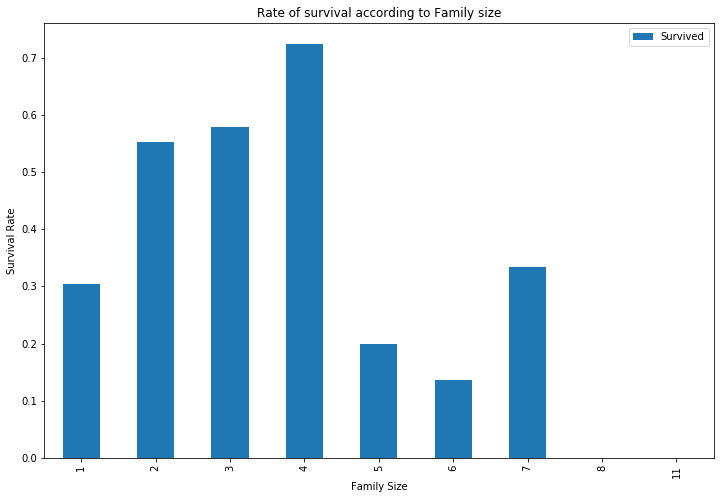

In [156]:
df.groupby('Survived')['Family Size'].value_counts()
perc_surv = df[['Survived', 'Family Size']].groupby(['Family Size']).mean()
perc_surv
ax = perc_surv.plot.bar(figsize = [12,8])
plt.title('Rate of survival according to Family size')
plt.ylabel('Survival Rate')

In [157]:
# Engineering a new attribute 'Alone/Not ALone'
df['Alone/Not Alone'] = 'Alone'
df.loc[df['Family Size'] > 1, 'Alone/Not Alone'] = 'Not Alone'
df.head()
# We can now safely drop the attribute 'Family Size' from the dataframe
df = df.drop(['Family Size'], axis = 1)
df.head()

,Survived,Pclass,Name,Sex,Age,Fare,Embarked,Family Size,Alone/Not Alone
0,0,3,"Braund, Mr. Owen Harris",male,22.0,7.2500,S,2,Not Alone
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,71.2833,C,2,Not Alone
2,1,3,"Heikkinen, Miss. Laina",female,26.0,7.9250,S,1,Alone
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,53.1000,S,2,Not Alone
4,0,3,"Allen, Mr. William Henry",male,35.0,8.0500,S,1,Alone


,Survived,Pclass,Name,Sex,Age,Fare,Embarked,Alone/Not Alone
0,0,3,"Braund, Mr. Owen Harris",male,22.0,7.2500,S,Not Alone
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,71.2833,C,Not Alone
2,1,3,"Heikkinen, Miss. Laina",female,26.0,7.9250,S,Alone
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,53.1000,S,Not Alone
4,0,3,"Allen, Mr. William Henry",male,35.0,8.0500,S,Alone


Survived  Alone/Not Alone
0         Alone              374
          Not Alone          175
1         Not Alone          179
          Alone              163
Name: Alone/Not Alone, dtype: int64

,Survived
Alone/Not Alone,
Alone,0.303538
Not Alone,0.505650


Text(0.5,1,'Rate of Survival of Passengers who were Alone vs Not Alone')

Text(0,0.5,'Survival Rate (%)')

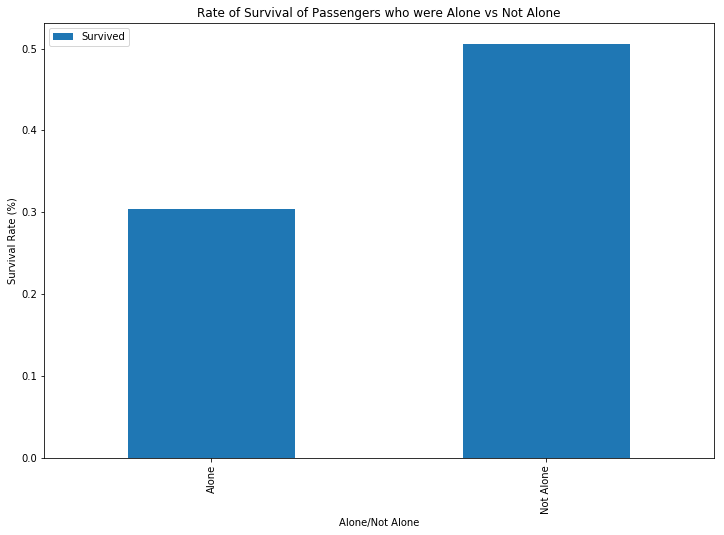

In [158]:
df.groupby('Survived')['Alone/Not Alone'].value_counts()
perc_surv = df[['Alone/Not Alone', 'Survived']].groupby(['Alone/Not Alone']).mean()
perc_surv
ax = perc_surv.plot.bar(figsize = [12,8])
plt.title('Rate of Survival of Passengers who were Alone vs Not Alone')
plt.ylabel('Survival Rate (%)')

Conclusion: Based on the above analysis, families with 4 members had the best chance of survival. Overall, we can conclude that passengers who were not alone had a survival rate of 50.56% compared to the 30.35% survival rate of passengers who were alone. 

## Port of Embarkation vs Survival

The passengers aboard the titanic embarked at 3 different locations: C = Cherbourg, Q = Queenstown, S = Southampton. Let's now determine whether the port of embarkation had an effect on survival.

Survived  Embarked
0         S           427
          C            75
          Q            47
1         S           219
          C            93
          Q            30
Name: Embarked, dtype: int64

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.339009


Text(0.5,1,'Rate of survival according to Port of Embarkation')

Text(0,0.5,'Survival Rate(%)')

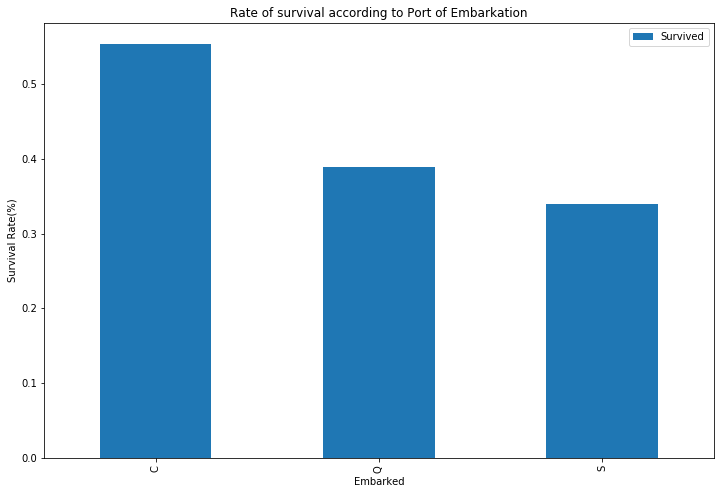

In [159]:
df.groupby('Survived')['Embarked'].value_counts()
perc_surv = df[['Survived', 'Embarked']].groupby(['Embarked']).mean()
perc_surv
ax = perc_surv.plot.bar(figsize = [12,8])
plt.title('Rate of survival according to Port of Embarkation')
plt.ylabel('Survival Rate(%)')

In [160]:
# Lets do a further analysis as to why the passengers who embarked from Cherbourg had a much 
# higher survivability rate when compared to the other ports of embarkation.
# Creating a pivot table which shows us the indepth statistics of certian attributes 
emb_analysis1 = df.pivot_table(values = ['Pclass', 'Fare'], index = ['Embarked','Sex','Alone/Not Alone'], 
                                    aggfunc = {'Pclass': 'mean', 'Fare': 'mean', 'Alone/Not Alone': len})
emb_analysis1
#Let's now create a more general table for summarizing the statistics to formulate a conclusion
group = df.groupby(['Embarked','Sex'])
emb_analysis2 = group.agg({'Fare': 'mean', 'Pclass': 'mean'})
emb_analysis2

Alone/Not Alone       Fare    Pclass
Embarked Sex    Alone/Not Alone                                      
C        female Alone                         25  89.664668  1.480000
                Not Alone                     48  67.620398  1.854167
         male   Alone                         60  33.128265  2.166667
                Not Alone                     35  74.205843  1.742857
Q        female Alone                         27   8.095685  2.925926
                Not Alone                      9  26.252778  2.777778
         male   Alone                         30   8.641527  2.966667
                Not Alone                     11  28.013636  2.818182
S        female Alone                         74  28.080181  2.189189
                Not Alone                    131  45.392940  2.183206
         male   Alone                        321  14.399528  2.467290
                Not Alone                    120  41.272848  2.300000

Fare    Pclass
Embarked Sex                        
C        female  75.169805  1.726027
         male    48.262109  2.010526
Q        female  12.634958  2.888889
         male    13.838922  2.926829
S        female  39.143456  2.185366
         male    21.711996  2.421769

Conclusion: On average, passengers who embarked from Cherbourg had a survival rate of 55.35% whereas the passengers who embarked from Queenstown and Southampton had a survival rate of 38.96% and 33.90% respectively. Even though the port of embarkation doesnt directly have an effect on survival, based on the analysis above, we can conclude that the passengers who embarked from Cherbourg, particularly the female passengers, paid a much larger fare and were in a higher ticket class (Pclass) on average when compared to the other two ports of embarkation. Thus, passengers who embarked from Cherbourg had an increased chance of survival due to these factors.

## Fare vs Survival

Let's now determine the survival rate of the passengers based on the fare that they paid. I will first engineer a new attribute called 'Fare Range' which will consist of 5 roughly equal-sized bins. This enables us to determine the survivability of the passengers based on the different fare ranges and also which fare range was the best in terms of survival.

Text(0.5,1,'Fare Distribution')

Text(0.5,0,'Amount')

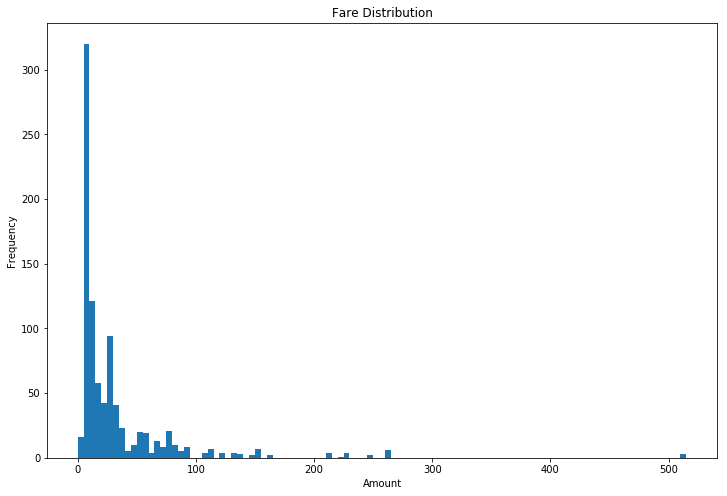

In [161]:
# Let's briefly look at the distrubution of the fare in a histogram
fare_dist_plot = df.Fare.plot.hist(bins = range(0,520,5), figsize = [12,8]) 
plt.title('Fare Distribution')
plt.xlabel('Amount')

In [162]:
# Engineering a new attribute called 'Fare Range'
df['Fare Range'] = pd.qcut(df.Fare, 5)
df.head()
# We can now safely drop the 'Fare' attribute
df = df.drop(['Fare'], axis = 1)
df.head()

,Survived,Pclass,Name,Sex,Age,Fare,Embarked,Alone/Not Alone,Fare Range
0,0,3,"Braund, Mr. Owen Harris",male,22.0,7.2500,S,Not Alone,"(-0.001, 7.854]"
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,71.2833,C,Not Alone,"(39.688, 512.329]"
2,1,3,"Heikkinen, Miss. Laina",female,26.0,7.9250,S,Alone,"(7.854, 10.5]"
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,53.1000,S,Not Alone,"(39.688, 512.329]"
4,0,3,"Allen, Mr. William Henry",male,35.0,8.0500,S,Alone,"(7.854, 10.5]"


,Survived,Pclass,Name,Sex,Age,Embarked,Alone/Not Alone,Fare Range
0,0,3,"Braund, Mr. Owen Harris",male,22.0,S,Not Alone,"(-0.001, 7.854]"
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,C,Not Alone,"(39.688, 512.329]"
2,1,3,"Heikkinen, Miss. Laina",female,26.0,S,Alone,"(7.854, 10.5]"
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,S,Not Alone,"(39.688, 512.329]"
4,0,3,"Allen, Mr. William Henry",male,35.0,S,Alone,"(7.854, 10.5]"


Survived  Fare Range       
0         (7.854, 10.5]        147
          (-0.001, 7.854]      140
          (21.679, 39.688]     100
          (10.5, 21.679]        99
          (39.688, 512.329]     63
1         (39.688, 512.329]    113
          (21.679, 39.688]      80
          (10.5, 21.679]        73
          (-0.001, 7.854]       39
          (7.854, 10.5]         37
Name: Fare Range, dtype: int64

,Survived
Fare Range,
"(-0.001, 7.854]",0.217877
"(7.854, 10.5]",0.201087
"(10.5, 21.679]",0.424419
"(21.679, 39.688]",0.444444
"(39.688, 512.329]",0.642045


Text(0.5,1,'Rate of Survival according to Fare')

Text(0,0.5,'Survival Rate (%)')

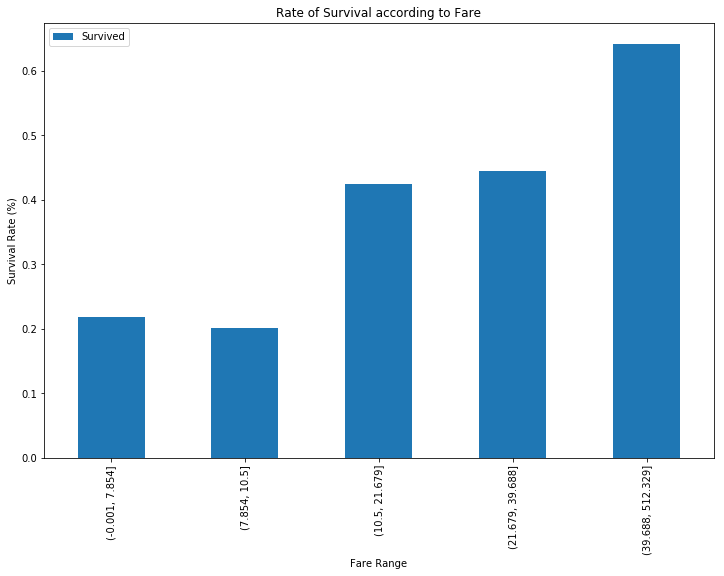

In [163]:
df.groupby('Survived')['Fare Range'].value_counts()
surv_perc = df[['Survived', 'Fare Range']].groupby(['Fare Range']).mean()
surv_perc
ax = surv_perc.plot.bar(figsize = [12,8])
plt.title('Rate of Survival according to Fare')
plt.ylabel('Survival Rate (%)')

Conclusion: It is evident that the passengers who paid in the fare range of (39.688, 512.329] had the best chance of survival at 64.2%. 

## Age vs Survival 

Finally, let's analyze how age had an effect on survival. I will first engineer a new attribute called 'Age Category' which will consist of 3 different age categories: Child (0-17 years old), Adult (18-64 years old) and Senior (65+ years old). This will allow us to determine which age groups had the top priority of being saved/rescued and thus the best chance of survival.

In [164]:
# Engineering a new attribute called Age Category
df['Age Category'] = 'Child'
df.loc[(df['Age'] >= 18) & (df['Age'] <= 64), 'Age Category'] = 'Adult'
df.loc[df['Age'] >= 65, 'Age Category'] = 'Senior'
df.head()
# We can now safely drop the 'Age' attribute
df = df.drop(['Age'], axis = 1)
df.head()

,Survived,Pclass,Name,Sex,Age,Embarked,Alone/Not Alone,Fare Range,Age Category
0,0,3,"Braund, Mr. Owen Harris",male,22.0,S,Not Alone,"(-0.001, 7.854]",Adult
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,C,Not Alone,"(39.688, 512.329]",Adult
2,1,3,"Heikkinen, Miss. Laina",female,26.0,S,Alone,"(7.854, 10.5]",Adult
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,S,Not Alone,"(39.688, 512.329]",Adult
4,0,3,"Allen, Mr. William Henry",male,35.0,S,Alone,"(7.854, 10.5]",Adult


,Survived,Pclass,Name,Sex,Embarked,Alone/Not Alone,Fare Range,Age Category
0,0,3,"Braund, Mr. Owen Harris",male,S,Not Alone,"(-0.001, 7.854]",Adult
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,C,Not Alone,"(39.688, 512.329]",Adult
2,1,3,"Heikkinen, Miss. Laina",female,S,Alone,"(7.854, 10.5]",Adult
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,S,Not Alone,"(39.688, 512.329]",Adult
4,0,3,"Allen, Mr. William Henry",male,S,Alone,"(7.854, 10.5]",Adult


Survived  Age Category
0         Adult           472
          Child            67
          Senior           10
1         Adult           273
          Child            68
          Senior            1
Name: Age Category, dtype: int64

,Survived
Age Category,
Adult,0.366443
Child,0.503704
Senior,0.090909


Text(0.5,1,'Rate of Survival according to Age Category')

Text(0,0.5,'Survival Rate(%)')

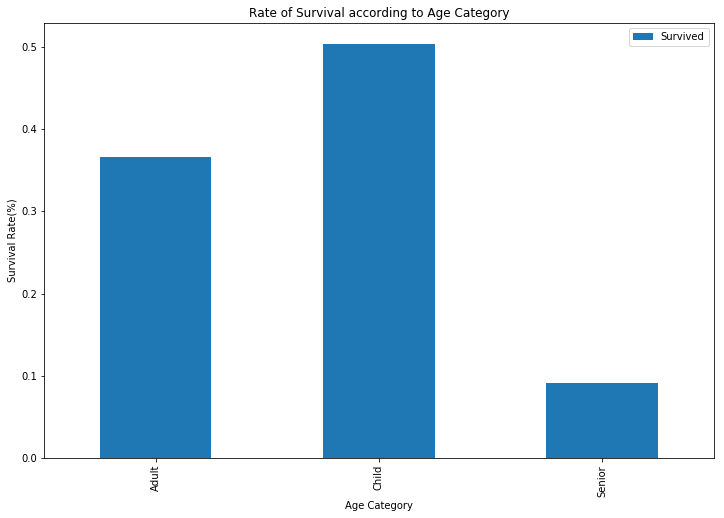

In [165]:
df.groupby('Survived')['Age Category'].value_counts()
surv_perc = df[['Survived', 'Age Category']].groupby(['Age Category']).mean()
surv_perc
ax = surv_perc.plot.bar(figsize = [12,8])
plt.title('Rate of Survival according to Age Category')
plt.ylabel('Survival Rate(%)')

Conclusion: Based on the above analysis, it can be concluded that children (0-17 years old) had the best chance of survival at 50.37%.  

## Name/Title vs Survival

I want to determine if the name/title of a passenger aboard the titanic had an influence on the survival rate. I will first use extract the salutations and then I will add a new column called Title to the end of the dataframe which will contain the title of that passenger.

In [166]:
df['Title'] = df.Name.map(lambda x: x.split(',')[1].split('.')[0].strip())
list(df.Title.unique())
df = df.drop(['Name'], axis = 1)
df.head()

['Mr',
 'Mrs',
 'Miss',
 'Master',
 'Don',
 'Rev',
 'Dr',
 'Mme',
 'Ms',
 'Major',
 'Lady',
 'Sir',
 'Mlle',
 'Col',
 'Capt',
 'the Countess',
 'Jonkheer']

,Survived,Pclass,Sex,Embarked,Alone/Not Alone,Fare Range,Age Category,Title
0,0,3,male,S,Not Alone,"(-0.001, 7.854]",Adult,Mr
1,1,1,female,C,Not Alone,"(39.688, 512.329]",Adult,Mrs
2,1,3,female,S,Alone,"(7.854, 10.5]",Adult,Miss
3,1,1,female,S,Not Alone,"(39.688, 512.329]",Adult,Mrs
4,0,3,male,S,Alone,"(7.854, 10.5]",Adult,Mr


In [167]:
df.Title.value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Mlle              2
Col               2
Capt              1
Lady              1
Jonkheer          1
Mme               1
Don               1
Sir               1
Ms                1
the Countess      1
Name: Title, dtype: int64

In [170]:
# Combining low value count titles into a category called Rare
df['Title'] = df.Title.replace(['Dr', 'Rev', 'Major', 'Col', 'Capt', 'Lady', 'Jonkheer', 'Don', 'Sir', 'the Countess'], 'Rare')
df['Title'] = df.Title.replace(['Mlle', 'Ms'], 'Miss')
df['Title'] = df.Title.replace('Mme', 'Mrs')

df.Title.value_counts()

Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: Title, dtype: int64

Survived  Title 
0         Mr        436
          Miss       55
          Mrs        26
          Master     17
          Rare       15
1         Miss      130
          Mrs       100
          Mr         81
          Master     23
          Rare        8
Name: Title, dtype: int64

,Survived
Title,
Master,0.575000
Miss,0.702703
Mr,0.156673
Mrs,0.793651
Rare,0.347826


Text(0.5,1,'Rate of Survival according to Title')

Text(0,0.5,'Survival Rate(%)')

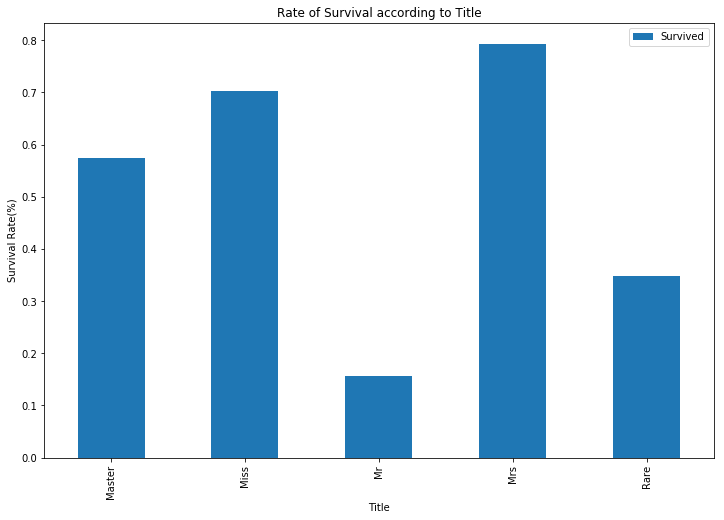

In [171]:
df.groupby('Survived')['Title'].value_counts()
surv_perc = df[['Survived', 'Title']].groupby(['Title']).mean()
surv_perc
ax = surv_perc.plot.bar(figsize = [12,8])
plt.title('Rate of Survival according to Title')
plt.ylabel('Survival Rate(%)')

Conclusion: It is evident that passengers with the salutations of Mrs, Miss and Master had the best chance of survival at 79.36%, 70.27%, and 57.5% respectively.

Based on this analysis, the categories of passengers who were most likely to survive the titanic disaster were: females, passengers with 1st class tickets, passengers with families larger than 1 (i.e. not alone), passengers who embarked from Cherbourg, passengers who paid in the upper fare range of (39.688, 512.329], and children (0-17 years old). 

## Creating Dummy Varibables

In [173]:
array = list(df.columns)[1:]

def dummy(df, array):
    for i in array:
        dummy = pd.get_dummies(df[i], prefix = i)
        df = df.drop(i, axis = 1)
        df = pd.concat([df, dummy], axis = 1)
    return df

df = dummy(df, array)
df.head()

,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Alone/Not Alone_Alone,...,"Fare Range_(21.679, 39.688]","Fare Range_(39.688, 512.329]",Age Category_Adult,Age Category_Child,Age Category_Senior,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,0,0,0,1,0,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
1,1,1,0,0,1,0,1,0,0,0,...,0,1,1,0,0,0,0,0,1,0
2,1,0,0,1,1,0,0,0,1,1,...,0,0,1,0,0,0,1,0,0,0
3,1,1,0,0,1,0,0,0,1,0,...,0,1,1,0,0,0,0,0,1,0
4,0,0,0,1,0,1,0,0,1,1,...,0,0,1,0,0,0,0,1,0,0


## Feature Selection and Modeling

Text(0,0.5,'Score')

Text(0.5,1,'Chi-square test scores')

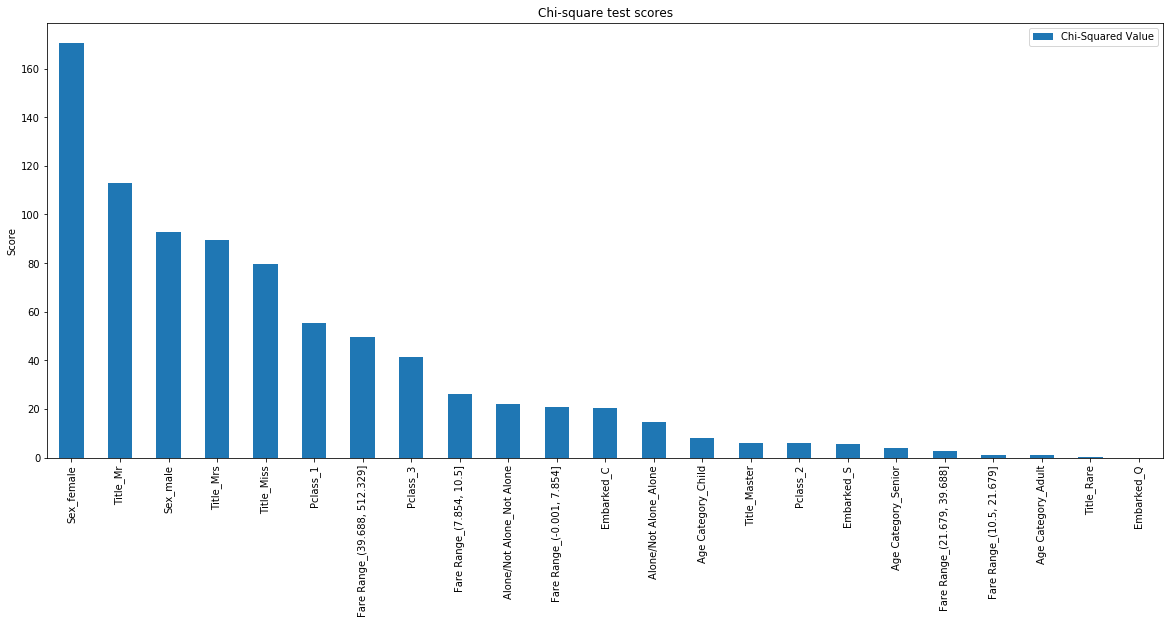

In [365]:
models = {'Gaussian Naive Bayes': GaussianNB(),
          'Decision Tree': DecisionTreeClassifier(),
          'Logistic Regression': LogisticRegression(),
          'k-Nearest Neighbors': KNeighborsClassifier(),
          'Random Forrest': RandomForestClassifier()}

array = df.values

X = array[:,1:]
Y = array[:,0]

chi2_selector = SelectKBest(chi2, k = 23)
X_kbest = chi2_selector.fit(X, Y)
X_features = X_kbest.transform(X)

df2 = pd.DataFrame(list(X_kbest.scores_), index = list(df.columns[1:]), columns = ['Chi-Squared Value'])        
df2.sort_values('Chi-Squared Value', ascending = False).plot.bar(figsize = (20,8))
plt.ylabel('Score')
plt.title('Chi-square test scores')  

In [368]:
# Using the top 19 scoring varibales in the predicitve models identified in the Chi-square test
X = df[df2.sort_values('Chi-Squared Value', ascending = False).index[:19]]

for keys in models.keys():
    validation_size = 0.20
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = validation_size, random_state = 28)
    clf = models[keys]
    clf.fit(X_train, Y_train) 
    pred_clf = clf.predict(X_test)

    train_score = 'Train score: {0:.1f}'.format(clf.score(X_train, Y_train)*100)
    test_score = 'Test score: {0:.1f}'.format(clf.score(X_test, Y_test)*100)
    
    train_score
    test_score

GaussianNB(priors=None)

'Train score: 78.7'

'Test score: 79.3'

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

'Train score: 85.8'

'Test score: 84.9'

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

'Train score: 81.9'

'Test score: 84.4'

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

'Train score: 83.3'

'Test score: 82.7'

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

'Train score: 85.7'

'Test score: 86.6'